In [1]:
from tensorflow.keras.layers import BatchNormalization, ReLU, Conv2D, Add, GlobalAveragePooling2D, Dense, Input, Conv2DTranspose, Reshape, Activation, Flatten, Embedding, Concatenate, AveragePooling2D, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import os

from generator import generator_network
from discriminator import discriminator_network
from classifier import classifier

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
!pip install wandb

In [3]:
import wandb

In [4]:
!pip freeze > requirements.txt


In [4]:
wandb.login(key=os.environ["WANDB_API_KEY"])

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
NUM_EPOCHS = 10
BUFFER_SIZE = 60000
BATCH_SIZE = 2

In [6]:
wandb.init(
      # Set the project where this run will be logged
      project="Triple-BiGGAN", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"Kaggle-Experiment-2",
      # Track hyperparameters and run metadata
      config={
      "architecture": "Triple-BiGGAN",
      "dataset": "CIFAR-10",
      "epochs": NUM_EPOCHS,
      })

wandb: Currently logged in as: rquaicoo (triple-big-gan). Use `wandb login --relogin` to force relogin


In [7]:
(train_imgs, train_labels), (test_imgs, test_labels) = cifar10.load_data()
wandb.log({"training data": train_imgs})

170498071/170498071 [==============================] - 2s 0us/step


In [8]:
print(train_imgs.shape, test_imgs.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [9]:
np.random.seed(42)

# Generate random indices
random_indices = np.random.choice(len(train_imgs), size=1000, replace=False)

# Select random images and labels
random_train_imgs = train_imgs[random_indices]
random_train_labels = train_labels[random_indices]

In [10]:
print("Shape of random_train_imgs:", random_train_imgs.shape)
print("Shape of random_train_labels:", random_train_labels.shape)

Shape of random_train_imgs: (1000, 32, 32, 3)
Shape of random_train_labels: (1000, 1)


In [11]:
# Resize images
resized_images = tf.image.resize(random_train_imgs, [256, 256])

In [12]:
print(resized_images.shape)

(1000, 256, 256, 3)


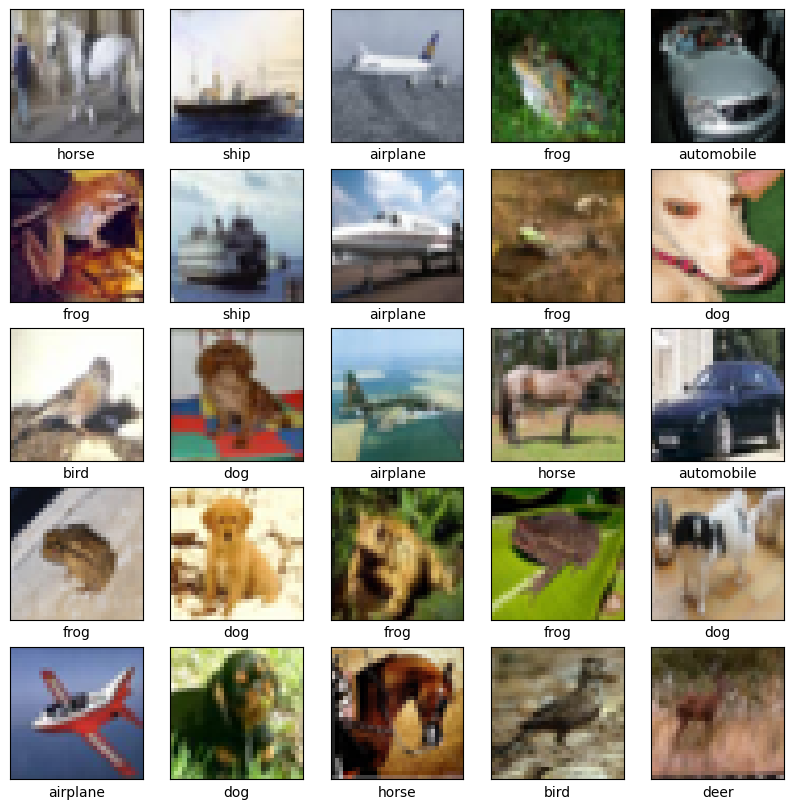

In [13]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))

for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(random_train_imgs[i])
  plt.xlabel(class_names[random_train_labels[i][0]])

plt.show()

In [14]:

#normalize resized images
normalized_resized_images = resized_images / 255.0
test_images = test_imgs / 255.0

In [15]:
num_classes = 10
train_labels = tf.keras.utils.to_categorical(random_train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

In [16]:
print(train_labels)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:
# Create a TensorFlow Dataset
#train_dataset = tf.data.Dataset.from_tensor_slices((resized_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices((resized_images, train_labels)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_imgs, test_labels))

In [18]:
print(train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [20]:
classifier = classifier()

94765736/94765736 [==============================] - 1s 0us/step


In [21]:
def orthogonal_regularizer(scale) :
  """ Defining the Orthogonal regularizer and return the function at last to be used in Conv layer as kernel regularizer"""

  def ortho_reg(w) :
      """ Reshaping the matrxi in to 2D tensor for enforcing orthogonality"""
      _, _, _, c = w.get_shape().as_list()

      w = tf.reshape(w, [-1, c])

      """ Declaring a Identity Tensor of appropriate size"""
      identity = tf.eye(c)

      """ Regularizer Wt*W - I """
      w_transpose = tf.transpose(w)
      w_mul = tf.matmul(w_transpose, w)
      reg = tf.subtract(w_mul, identity)

      """Calculating the Loss Obtained"""
      ortho_loss = tf.nn.l2_loss(reg)

      return scale * ortho_loss

  return ortho_reg

In [26]:
generator = generator_network()

shape (None, 32768)
(None, 4, 4, 2048)
(None, 8, 8, 2048)
(None, 16, 16, 1024)
(None, 32, 32, 1024)
(None, 64, 64, 512)
(None, 128, 128, 256)
(None, 256, 256, 128)
(None, 256, 256, 3)


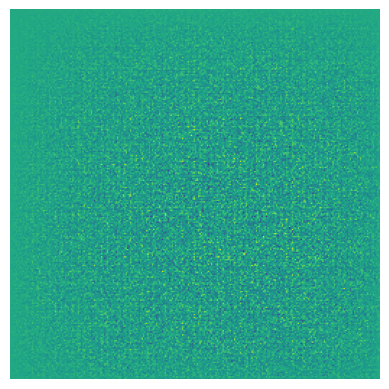

In [27]:
z_dim = 128
num_classes = 10
z = np.random.normal(size=(1, z_dim))
y = np.random.randint(0, num_classes, size=(1, num_classes))

generated_image = generator([z, y], training=False)


# Display the generated image
plt.imshow(generated_image[0, :, :, 0])
plt.axis('off')
plt.show()


In [30]:
discriminator = discriminator_network()

(None, 256, 256, 3)
(None, 128, 128, 128)
(None, 64, 64, 128)
(None, 32, 32, 256)
(None, 16, 16, 512)
(None, 8, 8, 1024)
(None, 4, 4, 2048)
(None, 1, 1, 2048)
(None, 1)


In [31]:
generator_optimizer = Adam(learning_rate=0.00005, beta_1=0, beta_2=0.999)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0, beta_2=0.999)
classifier_optimizer = Adam(learning_rate=0.0002, beta_1=0, beta_2=0.999)

In [32]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def calculate_classifier_loss(true_labels, predicted_labels):
  loss = tf.keras.losses.categorical_crossentropy(true_labels, predicted_labels)
  return loss

def calculate_generator_loss(fake_output):
  loss = binary_cross_entropy(tf.ones_like(fake_output), fake_output)

  return loss

def calculate_discriminator_loss(real_output, fake_output):
  real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = binary_cross_entropy(tf.zeros_like(fake_output), fake_output)

  return real_loss + fake_loss

In [33]:
classifier.compile(optimizer=classifier_optimizer,)
generator.compile(optimizer=generator_optimizer, )
discriminator.compile(optimizer=discriminator_optimizer,)

In [34]:
num_classes = 10
z_dim = 128

@tf.function
def train_step(images, labels):
    batch_size = images.shape[0]

    # Generate noise vector and random class embeddings
    noise = tf.random.normal([batch_size, z_dim])
    random_labels = tf.random.uniform([batch_size], minval=0, maxval=num_classes, dtype=tf.int32)
    class_embeddings = tf.one_hot(random_labels, depth=num_classes)
    print(class_embeddings, random_labels)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as class_tape:
        # Train the generator
        print("Training generator")
        generated_images = generator([noise, class_embeddings], training=True)

        # Train the discriminator
        print("Training discriminator with real input")
        real_output = discriminator([images, labels], training=True)

        print("Training the discriminator with fake input")
        fake_output = discriminator([generated_images, class_embeddings], training=True)

        # Classifier outputs for real and fake images
        print("Training classifier")
        predicted_labels = classifier(images, training = True)
        #fake_class_output = classifier(generated_images)

        # Calculate losses
        gen_loss = calculate_generator_loss(fake_output)
        disc_loss = calculate_discriminator_loss(real_output, fake_output)
        class_loss = calculate_classifier_loss(labels, predicted_labels)

    print("Calculating gradients")
    # Calculate gradients
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    class_gradients = class_tape.gradient(class_loss, classifier.trainable_variables)

    print("applying gradients")
    # Apply gradients
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    classifier_optimizer.apply_gradients(zip(class_gradients, classifier.trainable_variables))
    
    return gen_loss, disc_loss, class_loss


In [35]:
print(test_labels.shape)

(10000, 10)


In [ ]:
# Training loop
for epoch in range(NUM_EPOCHS):
    gen_train_loss = []
    disc_train_loss = []
    class_train_loss = []
    
    
    start = time.time()
    for real_images, real_labels in train_dataset:
        generator_loss, discriminator_loss, classifier_loss = train_step(real_images, real_labels)
        
        #print(np.mean(generator_loss), np.mean(discriminator_loss), classifier_loss)
        
        gen_train_loss.append(float(generator_loss))
        disc_train_loss.append(float(discriminator_loss))
        
        for loss in classifier_loss:
            class_train_loss.append(float(loss))

        #print(f"Epoch {epoch+1}/{num_epochs}")
        #print()
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    wandb.log({'epoch': epoch,
           'gen_loss': np.mean(gen_train_loss),
           'disc_loss': np.mean(disc_train_loss),
            'class_loss': np.mean(class_train_loss)
            })
  

# Save the trained models
generator.save_weights('generator_model.h5')
discriminator.save_weights('discriminator_model.h5')
classifier.save_weights('classifier_model.h5')

wandb.finish()



In [ ]:
def generate_fake_images(num_images):
    noise = tf.random.normal([num_images, z_dim])
    random_labels = tf.random.uniform([num_images], minval=0, maxval=num_classes, dtype=tf.int32)
    class_embeddings = tf.one_hot(random_labels, depth=num_classes)
    fake_images = generator([noise, class_embeddings], training=False)
    print(fake_images)
    return fake_images

In [ ]:
images = generate_fake_images(2)
fig = plt.figure(figsize=(4, 4))

for i in range(images.shape[0]):
  plt.subplot(4, 4, i+1)
  plt.imshow(images[i, :, :, 0])
  plt.axis('off')



In [9]:
!ls

requirements.txt


In [10]:
from IPython.display import FileLink

In [12]:
FileLink('requirements.txt')

/kaggle/working/requirements.txt